Import libraries

In [1]:
import math
import imp
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import skimage.transform
from mpl_toolkits.axes_grid1 import ImageGrid
import easydict
import csv
import pandas as pd

from scipy import stats

import dataprocessing as dp

Load data

In [2]:
Folder = "./pretrain_3DConv_Attention_LSTM_Stateful_3/"
dataFolder = "E:/Projects/ENSO/" #"./"
 
SSTFile_val = dataFolder+'/Data_validation/godas.input.1980_2017.nc'
SSTFile_val_label = dataFolder+'/Data_validation/godas.label.1980_2017.nc'


sstName='sst'
hcName='t300'
sstData =  dp.ReadData(SSTFile_val)
print(sstData)

sst = sstData[sstName][:, :, :, :]
hc = sstData[hcName][:, :, :, :]

print(sst.shape)
print(hc.shape)

sstData_label = dp.ReadData(SSTFile_val_label)
tr_y = sstData_label['pr'][:, :, :, :]
print(sstData_label)
print(tr_y.shape)

attention = np.load(Folder + "/Attention_Resize.npy")
attention = np.swapaxes(attention, 1, 3)
# attention[attention<np.max(attention)*0.5] = 0.0

print(attention.shape)
print(np.max(attention))
print(np.min(attention))

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    CDI: Climate Data Interface version 1.6.3 (http://code.zmaw.de/projects/cdi)
    Conventions: CF-1.4
    history: Wed Jul 24 11:55:33 2019: cdo -f nc import_binary set/godas.input.UNITY_ALL.1980_2017.ctl nc/godas.input.UNITY_ALL.1980_2017.nc
    CDO: Climate Data Operators version 1.6.3 (http://code.zmaw.de/projects/cdo)
    dimensions(sizes): lon(72), lat(24), lev(3), time(456)
    variables(dimensions): float64 lon(lon), float64 lat(lat), float64 lev(lev), float64 time(time), float32 sst(time,lev,lat,lon), float32 t300(time,lev,lat,lon)
    groups: 
(456, 3, 24, 72)
(456, 3, 24, 72)
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    CDI: Climate Data Interface version 1.6.3 (http://code.zmaw.de/projects/cdi)
    Conventions: CF-1.4
    history: Wed Oct 16 10:53:53 2019: cdo -f nc import_binary set/godas.nino.single.1980_2017.ctl nc/god

Correlation Analysis

C:\Users\Jaeil\AppData\Local\Programs\Python\Python36\lib\site-packages\scipy\stats\stats.py:3038: RuntimeWarning: invalid value encountered in float_scalars
  r = r_num / r_den
C:\Users\Jaeil\AppData\Local\Programs\Python\Python36\lib\site-packages\scipy\stats\stats.py:3042: RuntimeWarning: invalid value encountered in greater
  r = max(min(r, 1.0), -1.0)
C:\Users\Jaeil\AppData\Local\Programs\Python\Python36\lib\site-packages\scipy\stats\stats.py:3042: RuntimeWarning: invalid value encountered in less
  r = max(min(r, 1.0), -1.0)


MemoryError: 

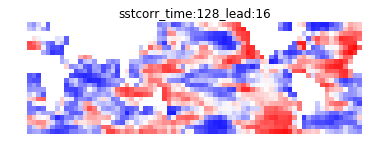

In [3]:
leadtime = 23

if not os.path.exists("CorrelationAnalysis_Win/"):
    os.makedirs("CorrelationAnalysis_Win/")

window = 6
saveDir = "CorrelationAnalysis_Win/" + str(window) + "/Img/"
if not os.path.exists(saveDir):
    os.makedirs(saveDir)

for l in range(leadtime):
    sstCorrMap = np.zeros((sst.shape[0], sst.shape[2], sst.shape[3]))
    hcCorrMap = np.zeros((sst.shape[0], sst.shape[2], sst.shape[3]))
    attCorrMap = np.zeros((sst.shape[0], sst.shape[2], sst.shape[3]))

    for te in range(window, sst.shape[0] - window):
        startIdx = te-window
        endIdx = te + window + 1
        #get answer
        y = tr_y[startIdx:endIdx, l, 0, 0]

        # # for t in range(sst.shape[1]):
        t = 1
        for lat in range(sst.shape[2]):
            for lon in range(sst.shape[3]):
                #sst 
                sstValues = sst[startIdx:endIdx, t, lat, lon]
                corr, p = stats.pearsonr(y, sstValues)
                sstCorrMap[te, lat, lon] = corr
                #hc
                hcValues = hc[startIdx:endIdx, t, lat, lon]
                corr, p = stats.pearsonr(y, hcValues)
                hcCorrMap[te, lat, lon] = corr
                
                #att
                attValues = attention[startIdx:endIdx, t, lat, lon]
                corr, p = stats.pearsonr(y, attValues)
                attCorrMap[te, lat, lon] = corr*np.linalg.norm(attValues)

        plt.imshow(sstCorrMap[te, :, :], cmap='bwr', vmin=-1.0, vmax=1.0)
        plt.axis('off')
        plt.gca().invert_yaxis()
        plt.title('sstcorr_time:{}_lead:{}'.format(te,l+1))
        plt.savefig(saveDir + 'sstcorr_{}_{}'.format(te,l+1), orientation='landscape', bbox_inches='tight')
        # plt.show()
        plt.close()

        plt.imshow(hcCorrMap[te, :, :], cmap='bwr', vmin=-1.0, vmax=1.0)
        plt.axis('off')
        plt.gca().invert_yaxis()
        plt.title('hccorr_time:{}_lead:{}'.format(te,l+1))
        plt.savefig(saveDir + 'hccorr_{}_{}'.format(te,l+1), orientation='landscape', bbox_inches='tight')
        # plt.show()
        plt.close()

        plt.imshow(attCorrMap[te, :, :], cmap='bwr', vmin=-1.0, vmax=1.0)
        plt.axis('off')
        plt.gca().invert_yaxis()
        plt.title('attcorr_time:{}_lead:{}'.format(te,l+1))
        plt.savefig(saveDir + 'attcorr_{}_{}'.format(te,l+1), orientation='landscape', bbox_inches='tight')
        # plt.show()
        plt.close()

    # # #save
    # np.save(saveDir + "sstCorr_{}".format(l+1), sstCorrMap)
    # np.save(saveDir + "hcCorr_{}".format(l+1), hcCorrMap)
    # np.save(saveDir + "attCorr_{}".format(l+1), attCorrMap)
    del sstCorrMap
    del hcCorrMap
    del attCorrMap


